In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import differential_evolution

from numba import njit

In [2]:
#colors
DARK_RED = '#b30000'
RED = '#ff0000'
GRAY = '#bfbfbf'
BLUE = '#4d94ff'
DARK_BLUE = '#0066ff'

## Links
- Media Sources by Dem/Rep: https://www.journalism.org/2020/01/24/americans-are-divided-by-party-in-the-sources-they-turn-to-for-political-news/
- Most common platform for news by Dem/Rep: https://www.journalism.org/2020/01/24/election-news-pathways-project-frequently-asked-questions/#ideological-composition-of-news-outlets-audiences
- News from social media 2021: https://www.pewresearch.org/fact-tank/2021/01/12/more-than-eight-in-ten-americans-get-news-from-digital-devices/
- Number of sources by Dem/Rep: https://www.pewresearch.org/pathways-2020/MAINSOPOL_USE/political_party/us_adults
- News from social media 2020: https://www.journalism.org/2020/07/30/americans-who-mainly-get-their-news-on-social-media-are-less-engaged-less-knowledgeable/
- Most common platform by Dem/Rep: https://www.pewresearch.org/pathways-2020/NEWS_MOST/political_party/us_adults
- Paper about Social Media and news consumption: https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.20191777
- Daily news consumption: https://www.americanpressinstitute.org/publications/reports/survey-research/americans-news-consumption/

In [21]:
@njit(nogil=True)
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]
        
@njit(nogil=True)
def optimize_step(steps, agent_approval_values, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media, agent_late_night, approval_types, neg_persuadability, pos_persuadability,
                  threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, 
                  late_night_const=-1, late_night_jokes=0, use_late_night=True):

    #agent_approval_values = starting_state
    
    media_values = np.array([1, 0.5, -0.5, -1, 0])

    polling_history = np.zeros((steps, 2))
    for current_step in range(steps):
        for i in range(num_agents):
            second_rate = 0
            rate = 0
            if consumption_rates[i] < 1:
                rate = consumption_rates[i]
            elif consumption_rates[i] > 1:
                rate = 1
                second_rate = consumption_rates[i] - 1

            will_consume = rand_choice_nb(np.array([True, False]), np.array([rate, 1-rate]))

            while will_consume:
                value = media_choices[i][current_step]
                if value is None: break

                kernel = value + coverage_leaning - agent_approval_values[i]
                if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
                    if value > 0:
                        neg_persuadability[i] -= abs(kernel) * persuadability_scale
                        if neg_persuadability[i] < 0: neg_persuadability[i] = 0
                        if neg_persuadability[i] > 1: neg_persuadability[i] = 1
                    elif value < 0:
                        pos_persuadability[i] -= abs(kernel) * persuadability_scale
                        if pos_persuadability[i] < 0: pos_persuadability[i] = 0
                        if pos_persuadability[i] > 1: pos_persuadability[i] = 1
                elif value != 0:
                    p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
                    agent_approval_values[i] += p*kernel*alpha
                will_consume = rand_choice_nb(np.array([True, False]), np.array([second_rate, 1-second_rate]))

            if uses_social_media[i]:
                p = pos_persuadability[i] if agent_approval_values[i] > 0 else neg_persuadability[i]
                x = np.abs(agent_approval_values[i])
                const = np.exp(-np.exp(1)*x) * social_media_const#(1-x)/(2*x+1)
                #const *= social_media_const
                agent_approval_values[i] += np.sign(agent_approval_values[i])*const * p

                
            if use_late_night:
                #arbitrary percents from 0 to 6
                percents = [0, 0.8/30, 2/30, 1/10, 2/7, 4/7]

                #also arbitrary amount?
                value = late_night_const
                if rand_choice_nb(np.array([True, False]), np.array([percents[agent_late_night[i]], 1-percents[agent_late_night[i]]])):
                    kernel = (late_night_const * late_night_jokes) - agent_approval_values[i]
                    if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
                        if value > 0:
                            neg_persuadability[i] -= abs(kernel) * persuadability_scale
                            if neg_persuadability[i] < 0: neg_persuadability[i] = 0
                            if neg_persuadability[i] > 1: neg_persuadability[i] = 1
                        elif value < 0:
                            pos_persuadability[i] -= abs(kernel) * persuadability_scale
                            if pos_persuadability[i] < 0: pos_persuadability[i] = 0
                            if pos_persuadability[i] > 1: pos_persuadability[i] = 1

                    else:#if value != 0:
                        p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
                        agent_approval_values[i] += p*kernel*alpha

            w = np.where((agent_approval_values[i] < (media_values + threshold)) & (agent_approval_values[i] > (media_values - threshold)))[0]

            if len(w):
                agent_approvals[i] = approval_types[w][0]
            
        
        approve = 0
        disapprove = 0
        no_opinion = 0
        for i in range(num_agents):
            if agent_approvals[i] == approval_types[0] or agent_approvals[i] == approval_types[1]:
                approve += 1
            elif agent_approvals[i] == approval_types[2] or agent_approvals[i] == approval_types[3]:
                disapprove += 1
            else:
                no_opinion += 1
        polling_history[current_step] = [100*approve/num_agents, 100*disapprove/num_agents]
    
    
    return polling_history#, 100*no_opinion/num_agents]

In [22]:
#make media classes
class MediaOutlet:
    def __init__(self, name, political_leaning, mcb_ideology):#, mcb_education, mcb_age)
        self.name = name
        self.political_leaning = political_leaning#[dem, Dlean, mod, Rlean, rep]  0 or 1 by what media place is
        
        #Media Consumption by...
        self.mcb_ideology = mcb_ideology#[dem, Dlean, Rlean, rep]  % of that group that consumes

    def __str__(self):
        return self.name
     
    def get_value(self):
        values = [-1, -0.5, 0, 0.5, 1]
        return values[self.political_leaning.index(1)]      
    

In [23]:
#make agent class
class Agent:
    def __init__(self, approval, ideology, approval_value):
        self.assigned_media_sources = []
        self.consumption_rate = 0

        #demographic information
        self.approval = approval
        self.ideology = ideology
        
        self.approval_value = approval_value
        
        #using this set up gives us a steeper curve than above and also accounts for values outside of the bounds -1, 1
            #at 0 the persuadability is 0.269 rather then 0.5
        denom = np.exp(2)-1
        self.neg_persuadability = (np.exp(-approval_value+1)-1)/denom
        self.pos_persuadability = (np.exp(approval_value+1)-1)/denom
        
        self.uses_social_media = False
        
        self.late_night = 0
       
    
    def assign(self, media_outlet):
        self.assigned_media_sources.append(media_outlet)
        
        
    def stats(self):
        print(f'Ideology: {self.ideology}\nApproval: {self.approval}')

        print('\tMedia Sources: ', end='')
        for m in self.assigned_media_sources:
            print(m, end=', ')
        
        print(f'\n\tConsumption Frequency: {self.consumption_rate}', end='')
        
        oftenness = ['Never', 'Less than Once a Month', 'About Once a Month', 'Several Times a Month', 'Once a Week', 'Multiple Times A Week']
        print(f'\nWatches Late-Night: {oftenness[self.late_night]}')
            
    def consume_media(self):
        #return all the media bias values 
        return [m.get_value() for m in self.assigned_media_sources]

In [24]:
class Model:
    def __init__(self, num_agents, political_distribution, approval_matrix, media_array, distribution_threshold=0.1, platform_split=[[], []], use_late_night=False):
                                                                                                                    # %dem, %rep who use social media for news
        self.political_distribution = political_distribution 
            #[%, %, %] (for now, [D, R, indep])distrib of agents ideologies
            
        self.approval_matrix = np.array(approval_matrix)
        
            #[Dem, Rep, Ind] by [strongly app, somewhat app, somewhat disapp, strongly disapp, no approval]
                #matrix 
        
        self.media_array = media_array 
            #array of MediaOutlet objects to loop through
        
        self.platform_split = platform_split
        # %dem, %rep who use social media for news
        
        self.use_late_night = use_late_night

        #make the agents
        self.agents = [None]*num_agents
        self.agent_approval_values = np.zeros((num_agents, ))
        self.generate_agents(num_agents, distribution_threshold)
        
        self.starting_state = self.agent_approval_values.copy()
        self.starting_agent_op = [str(agent.approval) for agent in self.agents]
        
        
    def generate_agents(self, num_agents, distribution_threshold):
        #initialize agents with ideology and approval
            #approval is a continuous value normally distributed around the 4 poles within some threshold
        
        
        distribution = np.round(self.approval_matrix * self.political_distribution * num_agents / 10000)
        
        #account for rounding errors to meet the target distribution
        target = [.44, .52] #app, dis
        approvals = np.sum(distribution, axis=1)
        a = (approvals[0] + approvals[1])/len(self.agents)
        d = (approvals[2] + approvals[3])/len(self.agents)
        
        need_app = np.round((target[0] * num_agents) - (a * num_agents))
        need_dis = np.round((target[1] * num_agents) - (d * num_agents))
        
        #add approval evenly across strongly and somehwat approve and over all party types
        distribution[:2, :] += need_app//6
        distribution[2:4, :] += need_dis//6
        
        #just assign any extra agents randomly in the middle
        other = num_agents-np.sum(distribution, dtype=int)
        approval_choice = np.random.choice([1, 2, 4], other)
        party_choice = np.random.choice([0, 1, 2], other)
        for i in range(other): distribution[approval_choice[i], party_choice[i]] += 1
        
        current_agent = 0
        approval_types = ['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion']
        self.approval_types = np.array(approval_types)
        approval_values = [1, 0.5, -0.5, -1, 0]
        party_types = ["democrat", 'republican', 'independent']

        for index, approval_row in enumerate(distribution):
            for party_index, amount in enumerate(approval_row):
                amount = int(amount)
                self.agent_approval_values[current_agent:current_agent+amount] = np.random.normal(approval_values[index], distribution_threshold/3, (amount,)) 
                self.agents[current_agent:current_agent+amount] = [Agent(approval_types[index], party_types[party_index], self.agent_approval_values[current_agent+i]) for i in range(amount)]
                current_agent += amount

        self.assign_media()
        if self.use_late_night:
            self.assign_late_night()

            
            
    def assign_late_night(self):
        '''Watch Late Night? HR1_1 by PID
              Yes.   No
        Dem   54.    46
        Ind   34.    66
        Rep   26.    74


        How often? (Of those who said yes) HR2 by PID
              Mult/week     Once/Week.    Mult/month.    Once/month.    < once/month.     Never
        Dem.     51             18.           15.            5.               6.            5
        Ind      35.            17.           22.            10.              9.            7
        Rep      35.            18.           20             10               12            5
        '''
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'democrat')[0]
        inds = np.where(pids == 'independent')[0]
        reps  = np.where(pids == 'republican')[0]

        #from above polling
        dems_watch_LN = np.random.choice([True, False], len(dems), p=[.54, .46])
        inds_watch_LN = np.random.choice([True, False], len(inds), p=[.34, .66])
        reps_watch_LN = np.random.choice([True, False], len(reps), p=[.26, .74])

        LN_dems = np.where(dems_watch_LN)[0]
        LN_inds = np.where(inds_watch_LN)[0]
        LN_reps = np.where(reps_watch_LN)[0]

        LN_dems_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_dems), p=[.51, .18, .15, .05, .06, .05])
        LN_inds_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_inds), p=[.35, .17, .22, .10, .09, .07])
        LN_reps_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_reps), p=[.35, .18, .20, .10, .12, .05])

        for d in LN_dems: self.agents[d].late_night = LN_dems_watch_amount[list(LN_dems).index(d)]
        for i in LN_inds: self.agents[i].late_night = LN_inds_watch_amount[list(LN_inds).index(i)]
        for r in LN_reps: self.agents[r].late_night = LN_reps_watch_amount[list(LN_reps).index(r)]


    
    def assign_media(self):
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'democrat')[0]
        reps  = np.where(pids == 'republican')[0]

        dems_to_consume = np.array([int(np.round(media.mcb_ideology[0] * len(dems) / 100)) for media in self.media_array])
        reps_to_consume = np.array([int(np.round(media.mcb_ideology[-1] * len(reps) / 100)) for media in self.media_array])
        
        for i, agent in enumerate(self.agents):
            if i in dems:
                p = dems_to_consume/np.sum(dems_to_consume)
                index = rand_choice_nb(np.arange(len(self.media_array)), p)
                dems_to_consume[index] -= 1
                agent.assign(self.media_array[index])
            else:
                p = reps_to_consume/np.sum(reps_to_consume)
                #choice = np.random.choice(self.media_array, p=p)
                index = rand_choice_nb(np.arange(len(self.media_array)), p)
                reps_to_consume[index] -= 1
                agent.assign(self.media_array[index])
        
        
        #Social Media        
        to_consume = [0, 0]
        to_consume[0] = int(np.round(self.platform_split[0][1] * len(dems) / 100))
        to_consume[1] = int(np.round(self.platform_split[1][1] * len(reps) / 100))
        dem_agent_indices = np.random.choice(dems, size=to_consume[0], replace=False)
        rep_agent_indices = np.random.choice(reps, size=to_consume[1], replace=False)
        
        for ind in dem_agent_indices:
            self.agents[ind].uses_social_media = True
        for ind in rep_agent_indices:    
            self.agents[ind].uses_social_media = True   
            
        
        
        #Consumption Rate
        '''
        Those that closely read an article or watch a program
        More    Once    Less    Never     in a day
        39% 	29% 	30% 	2%
         |       |       |      |
         V       V       V      V
        1.5      1       .5     0         percentages * 100        
        '''
        rates = np.random.choice([1.5, 1, 0.5, 0], len(self.agents), p=[.39, .29, .3, .02])

        for ind, r in enumerate(rates):
            self.agents[ind].consumption_rate = r
            
        

    
    def simulate(self, steps, draw=False, threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, late_night_const=-1, late_night_jokes=0, use_starting_agents=False):
        if use_starting_agents:
            self.agent_approval_values = self.starting_state.copy()
            denom = np.exp(2)-1
            for i, agent in enumerate(self.agents):
                agent.approval = self.starting_agent_op[i]

                agent.neg_persuadability = (np.exp(-self.agent_approval_values[i]+1)-1)/denom
                agent.pos_persuadability = (np.exp(self.agent_approval_values[i]+1)-1)/denom
                            
        starting_value = np.average(self.agent_approval_values)
        starting_approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
        starting_polls = [(starting_approvals[0] + starting_approvals[1])/10, (starting_approvals[2] + starting_approvals[3])/10]
        
        #this needs to match approval types
        media_values = np.array([1, 0.5, -0.5, -1, 0])
        
        
        polling_history = np.zeros((steps+1, 2))
        polling_history[0] = starting_polls
        
        for current_step in range(steps):
            for i, agent in enumerate(self.agents):
                second_rate = 0
                rate = 0
                if agent.consumption_rate < 1:
                    rate = agent.consumption_rate 
                elif agent.consumption_rate > 1:
                    rate = 1
                    second_rate = agent.consumption_rate - 1
                
                will_consume = np.random.choice([True, False], p=[rate, 1-rate])
                
                while will_consume:
                    try:
                        value = np.random.choice(agent.consume_media())
                    except:
                        break
                    #if np.random.choice([True, False], p=[rate, 1-rate]):
                    #kernel = (value + coverage_leaning)/2 - self.agent_approval_values[i]
                    kernel = value + coverage_leaning - self.agent_approval_values[i]
                    if np.sign(value) == np.sign(self.agent_approval_values[i]) and abs(value) < abs(self.agent_approval_values[i]):
                        #change persuadability in opposite direction


                        if value > 0:
                            agent.neg_persuadability -= abs(kernel) * persuadability_scale
                            if agent.neg_persuadability < 0: agent.neg_persuadability = 0
                            if agent.neg_persuadability > 1: agent.neg_persuadability = 1
                        elif value < 0:
                            agent.pos_persuadability -= abs(kernel) * persuadability_scale
                            if agent.pos_persuadability < 0: agent.pos_persuadability = 0
                            if agent.pos_persuadability > 1: agent.pos_persuadability = 1


                    #'''change here to make 0-biased news sources do something'''
                    else:
                    #elif value != 0:
                        p = agent.pos_persuadability if kernel > 0 else agent.neg_persuadability
                        self.agent_approval_values[i] += p*kernel*alpha

                    
                    will_consume = np.random.choice([True, False], p=[second_rate, 1-second_rate])
                        
                        
                #now do social media
                if agent.uses_social_media:
                    p = agent.pos_persuadability if self.agent_approval_values[i] > 0 else agent.neg_persuadability
                    x = abs(self.agent_approval_values[i])
                    const = np.exp(-np.exp(1)*np.abs(x))#(1-x)/(2*x+1)
                    const *= social_media_const
                    self.agent_approval_values[i] += np.sign(self.agent_approval_values[i])*const * p


                if self.use_late_night:
                    #arbitrary percents from 0 to 6
                    percents = [0, 0.8/30, 2/30, 1/10, 2/7, 4/7]

                    #also arbitrary amount?
                    value = late_night_const
                    if np.random.choice([True, False], p=[percents[agent.late_night], 1-percents[agent.late_night]]):
                        kernel = (late_night_const * late_night_jokes) - self.agent_approval_values[i]
                        if np.sign(value) == np.sign(self.agent_approval_values[i]) and abs(value) < abs(self.agent_approval_values[i]):
                            #change persuadability in opposite direction
                            if value > 0:
                                agent.neg_persuadability -= abs(kernel) * persuadability_scale
                                if agent.neg_persuadability < 0: agent.neg_persuadability = 0
                                if agent.neg_persuadability > 1: agent.neg_persuadability = 1
                            elif value < 0:
                                agent.pos_persuadability -= abs(kernel) * persuadability_scale
                                if agent.pos_persuadability < 0: agent.pos_persuadability = 0
                                if agent.pos_persuadability > 1: agent.pos_persuadability = 1

                        else:#if value != 0:
                            p = agent.pos_persuadability if kernel > 0 else agent.neg_persuadability
                            self.agent_approval_values[i] += p*kernel*alpha

                w = np.where((self.agent_approval_values[i] < (media_values + threshold)) & (self.agent_approval_values[i] > (media_values - threshold)))[0]
                
                if len(w):
                    agent.approval = self.approval_types[w][0]

            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
            polling_history[current_step+1] = [100*(approvals[0] + approvals[1])/len(self.agents), 100*(approvals[2] + approvals[3])/len(self.agents)]
       
            if draw:             
                clear_output(wait=True)
                plt.figure(figsize=(15, 7))
                #plt.ylim([25, 75])
                plt.xlim([0, steps-1])
                plt.subplot(211)
                plt.plot(range(current_step+1), polling_history[:current_step+1, 0], label='Approval', linestyle='--', marker='o', color='orange')
                plt.legend()
                plt.subplot(212)
                plt.plot(range(current_step+1), polling_history[:current_step+1, 1], label='Disapproval', linestyle='--', marker='o', color='blue')
                plt.legend()
                plt.show()

       
        print(f'Average approval: {starting_value} -> {np.average(self.agent_approval_values)}')
        approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
        percents = [f'\n\t{self.approval_types[i]}: {100*starting_approvals[i] / len(self.agents)} -> {100*approvals[i] / len(self.agents)}%' for i in range(len(self.approval_types))]
        print("\nApproval Percentages: ", *percents)

        polls = [100*(approvals[0] + approvals[1])/len(self.agents), 100*(approvals[2] + approvals[3])/len(self.agents)]
        print(f"\nOverall Polling Change Predicted:\n\tApprove: {starting_polls[0]}% -> {polls[0]}%\n\tDisapprove: {starting_polls[1]}% -> {polls[1]}%")

        return polling_history      
        
        
        
        
    
    def media_landscape(self):
        #describe how the media outlets inputted are distributed politcally and how many people watch them
        #x is leaning, y is number of agents that use it
        
        plt.figure(figsize=(15, 5))
        y = np.zeros((len(self.media_array), ))
        
        for agent in self.agents:
            for media in agent.assigned_media_sources:
                y[self.media_array.index(media)] += 1
        plt.subplot(121)
        plt.bar(range(len(self.media_array)), y, label=[media.name for media in self.media_array])
        plt.xticks(ticks=range(len(self.media_array)), labels=[media.name for media in self.media_array], rotation='vertical')
        plt.xlabel("Media Outlets")
        plt.ylabel("Number of Agents")
        
        leanings = ['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right']
        yy = np.zeros((len(leanings), ))
        for i, media in enumerate(self.media_array):
            yy[media.political_leaning.index(1)] += y[i]
        plt.subplot(122)
        
            
        
        plt.pie(yy, labels=leanings, autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        plt.title("Media Political Leanings")
        
        #plt.pie(np.histogram([media.political_leaning.index(1) for media in self.media_array], bins=len(self.media_array[0].political_leaning))[0], labels=['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right'], autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        #plt.title("Media Political Leanings")
        plt.show()
        
        

In [25]:
                    '''political_leaning, mcb_ideology'''
CNN = MediaOutlet("CNN", [1, 0, 0, 0, 0], [53, 53, 24, 24])
MSNBC = MediaOutlet("MSNBC", [1, 0, 0, 0, 0], [33, 33, 14, 14])
HuffPost = MediaOutlet("HuffPost", [1, 0, 0, 0, 0], [12, 12, 3, 3])

#changed these to moderate
NBC = MediaOutlet("NBC", [0, 0, 1, 0, 0], [40, 40, 28, 28])
ABC = MediaOutlet("ABC", [0, 0, 1, 0, 0], [37, 37, 30, 30])
CBS = MediaOutlet("CBS", [0, 0, 1, 0, 0], [33, 33, 26, 26])


WashingtonPost = MediaOutlet("Washington Post", [0, 1, 0, 0, 0], [26, 26, 8, 8])
NewYorkTimes = MediaOutlet("New York Times", [0, 1, 0, 0, 0], [31, 31, 9, 9])
Politico = MediaOutlet("Politico", [0, 1, 0, 0, 0], [14, 14, 5, 5])
Time = MediaOutlet("Time", [0, 1, 0, 0, 0], [10, 10, 4, 4])
TheGuardian = MediaOutlet("The Guardian", [0, 1, 0, 0, 0], [8, 8, 3, 3])


NPR = MediaOutlet("NPR", [0, 0, 1, 0, 0], [30, 30, 11, 11])
BBC = MediaOutlet("BBC", [0, 0, 1, 0, 0], [22, 22, 10, 10])
WallStreetJournal = MediaOutlet("Wall Street Journal", [0, 0, 1, 0, 0], [15, 15, 11, 11])
USAToday = MediaOutlet("USA Today", [0, 0, 1, 0, 0], [13, 13, 10, 10])
TheHill = MediaOutlet("The Hill", [0, 0, 1, 0, 0], [8, 8, 5, 5])
Newsweek = MediaOutlet("Newsweek", [0, 0, 1, 0, 0], [7, 7, 3, 3])

#added cable since there is a difference
FoxNewsTV = MediaOutlet("Fox News Cable", [0, 0, 0, 1, 0], [23, 23, 60, 60])
NewYorkPost = MediaOutlet("New York Post", [0, 0, 0, 1, 0], [5, 5, 5, 5])
WashingtonExaminer = MediaOutlet("WashingtonExaminer", [0, 0, 0, 1, 0], [2, 2, 4, 4])

FoxNews = MediaOutlet("Fox News", [0, 0, 0, 0, 1], [23, 23, 60, 60])
Hannity = MediaOutlet("Hannity", [0, 0, 0, 0, 1], [1, 1, 19, 19])#made up
Limbaugh = MediaOutlet("Limbaugh", [0, 0, 0, 0, 1], [1, 1, 17, 17])#made up
Breitbart = MediaOutlet("Breitbart", [0, 0, 0, 0, 1], [0.5, 0.5, 8, 8])
DailyCaller = MediaOutlet("Daily Caller", [0, 0, 0, 0, 1], [0.5, 0.5, 3, 3])


media_outlets = [CNN, MSNBC, HuffPost, #BuzzFeed, Vox, 
                 NBC, ABC, CBS, WashingtonPost, NewYorkTimes, Politico, Time, TheGuardian, 
                 NPR, BBC, WallStreetJournal, USAToday, TheHill, Newsweek, 
                 FoxNews, FoxNewsTV, Hannity, NewYorkPost, WashingtonExaminer, 
                 Limbaugh, Breitbart, DailyCaller]

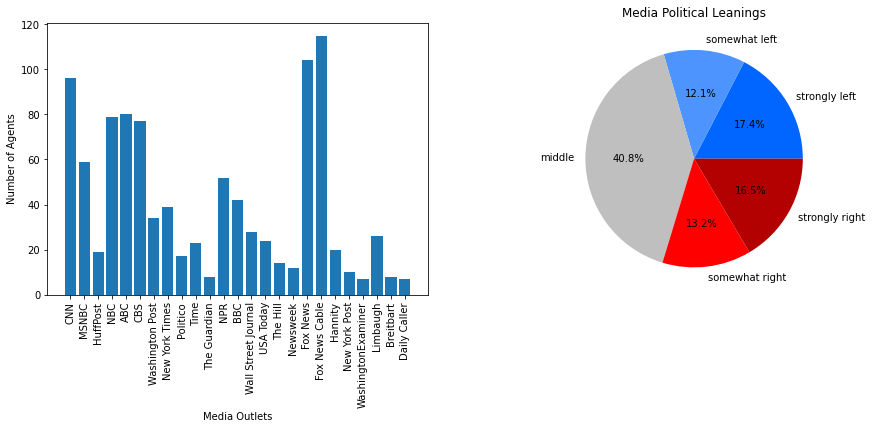

In [26]:
''' total = [44, 52, 4]
3/18/20 Ipsos poll [44, 37, 10],
[[5, 56, 14],
[8, 30, 23],
[18, 7, 21],
[67, 5, 32],
[2, 1, 10]]
'''
model = Model(1000, [44, 37, 10],
                [[5, 56, 14],
                [8, 30, 23],
                [18, 7, 21],
                [67, 5, 32],
                [2, 1, 10]], 
              media_outlets, distribution_threshold=0.5, platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], 
              use_late_night=False)

''' total = [42, 52, 6]
4/22/20 Ipsos poll [44, 37, 10],
[[3, 54, 17],
[6, 26, 17],
[14, 6, 17],
[73, 7, 39],
[4, 7, 10]]
'''

''' total = [41, 54, 5]
5/20/20 Ipsos poll [44, 37, 10],
[[4, 55, 12],
[4, 27, 20],
[11, 6, 17],
[76, 7, 34],
[5, 5, 17]]
'''

model.media_landscape()

In [9]:
r = np.random.randint(1000)
model.agents[r].stats()
model.agents[r].consume_media()

Ideology: democrat
Approval: strongly disapprove
	Media Sources: MSNBC, 
	Consumption Frequency: 0.5
Watches Late-Night: Never


[-1]

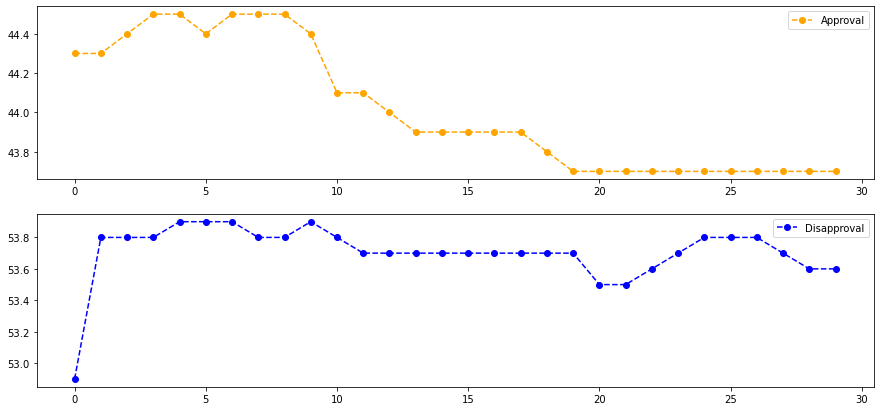

Average approval: -0.09574127809380314 -> -0.09930507848568981

Approval Percentages:  
	strongly approve: 25.5 -> 31.8% 
	somewhat approve: 18.8 -> 12.1% 
	somewhat disapprove: 16.0 -> 21.0% 
	strongly disapprove: 36.9 -> 32.6% 
	no opinion: 2.8 -> 2.5%

Overall Polling Change Predicted:
	Approve: 44.3% -> 43.9%
	Disapprove: 52.9% -> 53.6%


In [10]:
(threshold, alpha, persuadability_scale, social_media_const) = [0.37364163, 0.06361854, 0.4841436,  0.5254433 ]
late_night_const = -0.38006347
'''
Jokes/Day in Period 1: 4.202088452088452
Jokes/Day in Period 2: 4.8740165631469985
'''
late_night_jokes = 4.202088452088452

_ = model.simulate(30, draw=True, coverage_leaning=0, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


In [35]:
def estimate(t, x0, p, alpha, M, cl):
    f = np.math.factorial
    binom = 0
    expansion = 0
    for n in range(0, t+1):
        binom += f(t)*((-1)**(n)) * ((alpha * p)**n) / (f(n) * f(t-n))
        expansion += ((-1)**(n))*(t-n)*((alpha*p)**(n+1))*(M+cl)
    x = (binom)*x0 + expansion
    return x if not np.isnan(x) else 0
    
w = np.where([not model.agents[i].uses_social_media for i in range(len(model.agents))])

media_means = [np.mean(model.agents[i].consume_media()) for i in range(len(model.agents))]
alpha = 0.06361854
p = [abs(-np.sign(media_choices[i])- model.starting_state[i])/2 for i in range(len(model.agents))]

est_approval = np.array([estimate(30, model.starting_state[i], p[i], alpha, media_means[i], 0) for i in range(len(model.agents))])
plt.scatter(model.agent_approval_values[w], est_approval[w])
plt.show()

print(np.mean(abs(model.agent_approval_values[w] - est_approval[w])))
print(np.corrcoef(model.agent_approval_values[w], est_approval[w])[0][1])


NameError: name 'media_choices' is not defined

In [235]:
lean_str = ['Left', 'Lean Left', 'Middle', 'Lean Right', 'Right']
# leanings = [lean_str[] for m in media_outlets]
# names = [m.name for m in media_outlets]

frame = np.array([['']*5]*len(media_outlets), dtype='<U20')
for i, m in enumerate(media_outlets):
    index = m.political_leaning.index(1)
    frame[i][index] = m.name
pd.DataFrame(frame, columns=lean_str)

,Left,Lean Left,Middle,Lean Right,Right
0,CNN,,,,
1,MSNBC,,,,
2,HuffPost,,,,
3,,,NBC,,
4,,,ABC,,
5,,,CBS,,
6,,Washington Post,,,
7,,New York Times,,,
8,,Politico,,,
9,,Time,,,


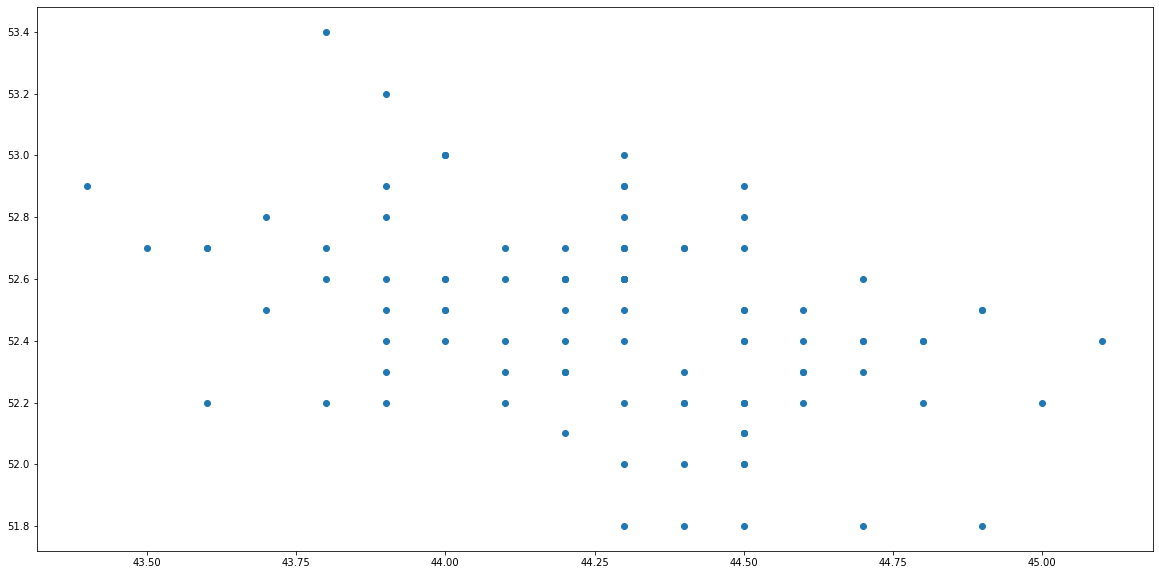

In [12]:
plt.figure(figsize=(20, 10))
#plt.plot([starting[:, 0], polling[:, 0]], [starting[:, 1], polling[:, 1]], 'o-')
# for i in range(len(polling)):
#     plt.arrow(starting[i, 0], starting[i, 1], polling[i, 0]-starting[i, 0], polling[i, 1]-starting[i, 1], length_includes_head=True, head_width=0.009)
plt.scatter(polling[:, 0], polling[:, 1])
plt.show()

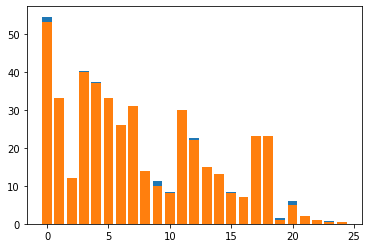

(array([ 32,  73, 247, 422, 550, 847], dtype=int64),)

In [60]:
d_chances = np.array([media.mcb_ideology[0] for media in media_outlets])/100
does_consume = np.zeros((num_agents, len(media_outlets)))

for i in range(num_agents):
    for j in range(len(media_outlets)):
        does_consume[i][j] = np.random.choice([True, False], p=[d_chances[j], 1-d_chances[j]])
        
plt.bar(range(len(media_outlets)), 100*np.sum(does_consume, axis=0)/1000)
plt.bar(range(len(media_outlets)), d_chances*100)
plt.show()

np.where(np.sum(does_consume, axis=1) == 0)

## Optimize

In [15]:
steps = 30
m = model
starting_state = m.starting_state.copy()
num_agents = len(m.agents)
agent_approvals = np.array([agent.approval for agent in m.agents])
approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
consumption_rates = np.array([agent.consumption_rate for agent in m.agents])

media_choices = np.zeros((num_agents, steps))
for i, agent in enumerate(m.agents):
    if len(agent.consume_media()) == 0:
        media_choices[i] = np.array([None]*steps)
    else:
        media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
neg_persuadability = np.zeros((num_agents,))
pos_persuadability = np.zeros((num_agents,))

denom = np.exp(2)-1
for i in range(num_agents):    
    neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
    pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

agent_late_night = np.array([agent.late_night for agent in m.agents])

In [ ]:
optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media,agent_late_night,approval_types,neg_persuadability,pos_persuadability,
                  threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, 
                  late_night_const=-1, late_night_jokes=0, use_late_night=True)

In [28]:
args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)

steps = 30
starting_state = m.starting_state.copy()
num_agents = len(m.agents)
agent_approvals = np.array([agent.approval for agent in m.agents])
approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
consumption_rates = np.array([agent.consumption_rate for agent in m.agents])

media_choices = np.zeros((num_agents, steps))
for i, agent in enumerate(m.agents):
    if len(agent.consume_media()) == 0:
        media_choices[i] = np.array([None]*steps)
    else:
        media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
neg_persuadability = np.zeros((num_agents,))
pos_persuadability = np.zeros((num_agents,))

denom = np.exp(2)-1
for i in range(num_agents):    
    neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
    pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

agent_late_night = np.array([agent.late_night for agent in m.agents])

result1 =  m.simulate(30,  threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, late_night_const=-1, late_night_jokes=0)

result2 = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media,agent_late_night,approval_types, neg_persuadability, pos_persuadability, threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1,  late_night_const=-1, late_night_jokes=0, use_late_night=True)

Average approval: -0.10146756091064055 -> -0.09484408815311718

Approval Percentages:  
	strongly approve: 25.5 -> 26.8% 
	somewhat approve: 19.0 -> 17.6% 
	somewhat disapprove: 15.5 -> 14.6% 
	strongly disapprove: 36.9 -> 37.6% 
	no opinion: 3.1 -> 3.4%

Overall Polling Change Predicted:
	Approve: 44.5% -> 44.4%
	Disapprove: 52.4% -> 52.2%


In [39]:
def optimize(m, polling_target, bounds, initial_guess, with_late_night=False):
    coverage_leaning = 0.05
    
    #first period
    late_night_jokes = 4.202088452088452
    late_night_const=0
    
    #get all the needed info first
    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)
    agent_approvals = np.array([agent.approval for agent in m.agents])
    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
    consumption_rates = np.array([agent.consumption_rate for agent in m.agents])
    media_choices = np.zeros((num_agents, steps))
    for i, agent in enumerate(m.agents):
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
        else:
            media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
    uses_social_media = np.array([agent.uses_social_media for agent in m.agents])
    agent_late_night = np.array([agent.late_night for agent in m.agents])
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))

    denom = np.exp(2)-1
    for i in range(num_agents):    
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
    args = (steps, starting_state, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media, agent_late_night, approval_types, coverage_leaning, late_night_jokes, neg_persuadability, pos_persuadability)
        

    def f(x, *args):
        (threshold, alpha, persuadability_scale, social_media_const) = x
        (steps, starting_state, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media, agent_late_night, approval_types, coverage_leaning, late_night_jokes, neg_persuadability, pos_persuadability) = args
        
        result = optimize_step(steps, starting_state.copy(), num_agents, agent_approvals.copy(), consumption_rates, media_choices.copy(), uses_social_media, agent_late_night, approval_types, neg_persuadability, pos_persuadability,
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False)
        result = result[-1]
        print(f'\r{result}', end=' ', flush=True)
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - polling_target[i])**2
        loss /= len(result)
        
        return loss
    
    
    def g(x, *args):
        (threshold, alpha, persuadability_scale, social_media_const, late_night_const) = x
        (steps, starting_state, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media, agent_late_night, approval_types, coverage_leaning, late_night_jokes, neg_persuadability, pos_persuadability) = args
        
        result = optimize_step(steps, starting_state.copy(), num_agents, agent_approvals.copy(), consumption_rates, media_choices.copy(), uses_social_media, agent_late_night, approval_types,neg_persuadability, pos_persuadability,
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True)
        result = result[-1]
        print(f'\r{result}', end=' ', flush=True)
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - polling_target[i])**2
        loss /= len(result)
        
        return loss

    if with_late_night:
        opt = differential_evolution(g, bounds, args=args, strategy='best1bin', disp=True)
    else:
        opt = differential_evolution(f, bounds, args=args, strategy='best1bin', disp=True)
        
    print(f'{[r for r in opt.x]}')
    return opt.x
    
    
    
    #return 
    #return minimize(f, initial_guess, bounds=bounds, method='Nelder-Mead')



In [40]:
'''SINGLE MODEL WITH LATE NIGHT'''
target = [42, 52, 6]

bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (-1, 0)]
initial_guess = [0.23785216662772357, 0.07870560089383177, 0.7682381927639791, 0.19322597697871924, -0.2531285067428999]

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)

results = optimize(m, target, bounds, initial_guess, with_late_night=True)

[40.3 52.2]  differential_evolution step 1: f(x)= 0.01
[45.9 54.1]  differential_evolution step 2: f(x)= 0.01
[38.6 54.7] differential_evolution step 3: f(x)= 0.01
[40.8 58.9] differential_evolution step 4: f(x)= 0.01
[42.5 52.3]   differential_evolution step 5: f(x)= 0.005
[42.2 52.1] differential_evolution step 6: f(x)= 0.005
[40.6 56.9] differential_evolution step 7: f(x)= 0
[42.5 52.1] differential_evolution step 8: f(x)= 0
[39.1 56.5] differential_evolution step 9: f(x)= 0
[38.6 52.4] differential_evolution step 10: f(x)= 0
[40.7 52.5] differential_evolution step 11: f(x)= 0
[42.7 51.7] differential_evolution step 12: f(x)= 0
[42.3 52.2] differential_evolution step 13: f(x)= 0
[42.6 52.4] differential_evolution step 14: f(x)= 0
[43.3 52. ] differential_evolution step 15: f(x)= 0
[42.1 52.1] differential_evolution step 16: f(x)= 0
[42.1 51.9] differential_evolution step 17: f(x)= 0
[42.4 52. ] differential_evolution step 18: f(x)= 0
[41.5 52.2]  differential_evolution step 19: f(x)

In [121]:
'''MULTIPLE RUNS'''

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

    
#first period
late_night_jokes = 4.202088452088452
coverage_leaning = 0.05

target = [42, 52, 6]
bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (-1, 0)]
initial_guess = [ 0.13944413,  0.06975399,  0.22779948,  0.95373104, -0.56726164]
iters = 10
def f(x):
    (threshold, alpha, persuadability_scale, social_media_const, late_night_const) = x
    losses = np.zeros((iters,))
    for i in range(iters):
        m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)

        steps = 30
        starting_state = m.starting_state.copy()
        num_agents = len(m.agents)
        
        approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
        

        media_choices = np.zeros((num_agents, steps))
        agent_approvals = []
        consumption_rates = np.zeros((num_agents, ))
        uses_social_media = []
        agent_late_night = []
        neg_persuadability = np.zeros((num_agents,))
        pos_persuadability = np.zeros((num_agents,))

        denom = np.exp(2)-1
        for i, agent in enumerate(m.agents):
            agent_approvals.append(agent.approval)
            consumption_rates[i] = agent.consumption_rate
            uses_social_media.append(agent.uses_social_media)
            agent_late_night.append(agent.late_night)
            neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
            pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
            if len(agent.consume_media()) == 0:
                media_choices[i] = np.array([None]*steps)
            else:
                media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
         
            
#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])

        result = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), approval_types, neg_persuadability, pos_persuadability, 
                      threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                      late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True)

        result = result[-1]
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - target[i])**2
        loss /= len(result)
        losses[i] = loss
        print(f"\r Loss: {loss:.4f}", end=' ', flush=True)
#     mean = np.mean(losses)
#     var = np.var(losses)
#     print(f'\r Mean: {mean}, Variance: {var}, Sum: {np.sum(losses)}', end=' ', flush=True)
    return np.sum(losses)

opt = differential_evolution(f, bounds, strategy='best1bin', disp=True, maxiter=25)
opt

 Loss: 12.2400  differential_evolution step 1: f(x)= 0.025
 Loss: 3.3800  differential_evolution step 2: f(x)= 0.025
 Loss: 0.1250  differential_evolution step 3: f(x)= 0.025
 Loss: 2.0800  differential_evolution step 4: f(x)= 0.02
 Loss: 17.6500 differential_evolution step 5: f(x)= 0.02
 Loss: 56.4100  differential_evolution step 6: f(x)= 0.02
 Loss: 2.4100  differential_evolution step 7: f(x)= 0.02
 Loss: 1.4500  differential_evolution step 8: f(x)= 0.02
 Loss: 0.2500  differential_evolution step 9: f(x)= 0.02
 Loss: 15.4600 differential_evolution step 10: f(x)= 0.02
 Loss: 0.0100  differential_evolution step 11: f(x)= 0.01
 Loss: 7.4500  differential_evolution step 12: f(x)= 0.005
 Loss: 0.9000  differential_evolution step 13: f(x)= 0.005
 Loss: 1.1050  differential_evolution step 14: f(x)= 0.005
 Loss: 1.1050  differential_evolution step 15: f(x)= 0
 Loss: 19.8050 differential_evolution step 16: f(x)= 0
 Loss: 0.1600  differential_evolution step 17: f(x)= 0
 Loss: 0.4450  different

     fun: 0.0
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 2058
     nit: 25
 success: False
       x: array([ 0.19276821,  0.04083252,  0.3499219 ,  0.5276154 , -0.5264669 ])

# Late Night

In [122]:
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = [ 0.13944413,  0.06975399,  0.22779948,  0.95373104, -0.56726164]#opt.x#

samples = 100
steps = 30

LN_period1 = np.zeros((samples, steps, 2))
LN_period2 = np.zeros((samples, steps, 2))
print('Gathering Samples...')
print('\r[' + '>' + '-'*19 + ']', end=' ', flush=True)
for k in range(samples):
    temp = int(k // (samples/20))
    if temp == 0: temp = 1
    print('\r[' + '='*(temp-1) + '>' + '-'*(20-temp) + ']', end=' ', flush=True)
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)


    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)

    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


    media_choices = np.zeros((num_agents, steps))
    agent_approvals = []
    consumption_rates = np.zeros((num_agents, ))
    uses_social_media = []
    agent_late_night = []
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))

    denom = np.exp(2)-1
    for i, agent in enumerate(m.agents):
        agent_approvals.append(agent.approval)
        consumption_rates[i] = agent.consumption_rate
        uses_social_media.append(agent.uses_social_media)
        agent_late_night.append(agent.late_night)
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
        else:
            media_choices[i] = np.random.choice(agent.consume_media(), (steps,))

#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])
    
    late_night_jokes = 4.202088452088452
    coverage_leaning = 0.05
    LN_period1[k] = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True)

    
    for i, agent in enumerate(m.agents):

        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
        else:
            media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
            
    late_night_jokes = 4.8740165631469985
    coverage_leaning = -0.25

    LN_period2[k] = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True)

Gathering Samples...
[==================>-] 

 Mean Approval Error: 1.3791666666666667
 Mean Disapproval Error: 1.1033333333333337


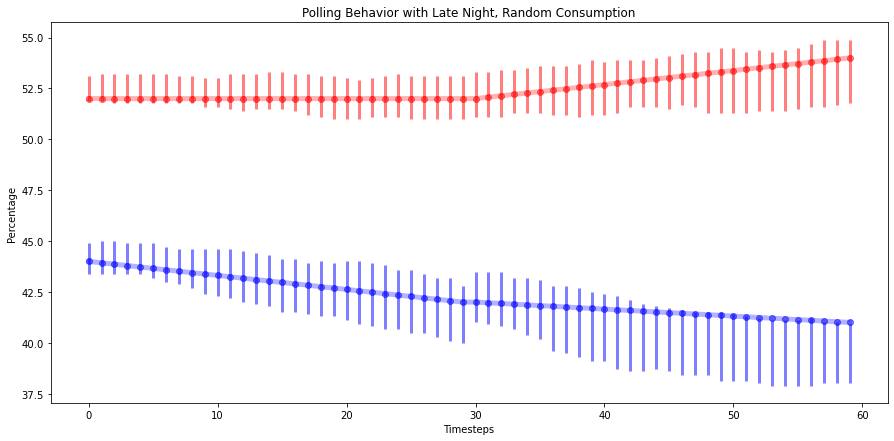

In [124]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
means = np.concatenate((np.mean(LN_period1, axis=0), np.mean(LN_period2, axis=0)))
approval = np.concatenate((LN_period1[:, :, 0], LN_period2[:, :, 0]), axis=1)
disapproval = np.concatenate((LN_period1[:, :, 1], LN_period2[:, :, 1]), axis=1)

app_err = (np.abs(ipsos_app - approval)).std(axis=0)#.mean()#approval.std(axis=0) * np.sqrt(1/len(approval[0]) + (approval - approval.mean(axis=0))**2 / np.sum((approval - approval.mean(axis=0))**2))
dis_err = (np.abs(ipsos_app - approval)).std(axis=0)#.mean()#disapproval.std() * np.sqrt(1/len(disapproval) + (disapproval - disapproval.mean())**2 / np.sum((disapproval - disapproval.mean())**2))

plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)


# p1_interval = st.t.interval(alpha=0.99, df=len(LN_period1)-1, loc=np.mean(LN_period1), scale=st.sem(LN_period1))
# p2_interval = st.t.interval(alpha=0.99, df=len(LN_period2)-1, loc=np.mean(LN_period2), scale=st.sem(LN_period2))

# app_interval = np.concatenate((p1_interval[0], p2_interval[0]))
# dis_interval = np.concatenate((p1_interval[1], p2_interval[1]))

# ax.plot(steps, means[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
# ax.fill_between(steps, app_interval[:, 0], app_interval[:, 1], alpha=0.2)
# ax.plot(steps, means[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
# ax.fill_between(steps, dis_interval[:, 0], dis_interval[:, 1], alpha=0.5)

maxes = np.max(approval, axis=0)
mins = np.min(approval, axis=0)
app_err = [ipsos_app-mins, maxes-ipsos_app]
plt.errorbar(steps, ipsos_app, yerr=app_err, fmt='o', color='blue',
             ecolor='blue', elinewidth=3, capsize=0, alpha=0.5)


maxes = np.max(disapproval, axis=0)
mins = np.min(disapproval, axis=0)
dis_err = [ipsos_dis-mins, maxes-ipsos_dis]

plt.errorbar(steps, ipsos_dis, yerr=dis_err, fmt='o', color='red',
             ecolor='red', elinewidth=3, capsize=0, alpha=0.5)

print(f' Mean Approval Error: {np.mean(app_err)}\n Mean Disapproval Error: {np.mean(dis_err)}')


<ErrorbarContainer object of 3 artists>

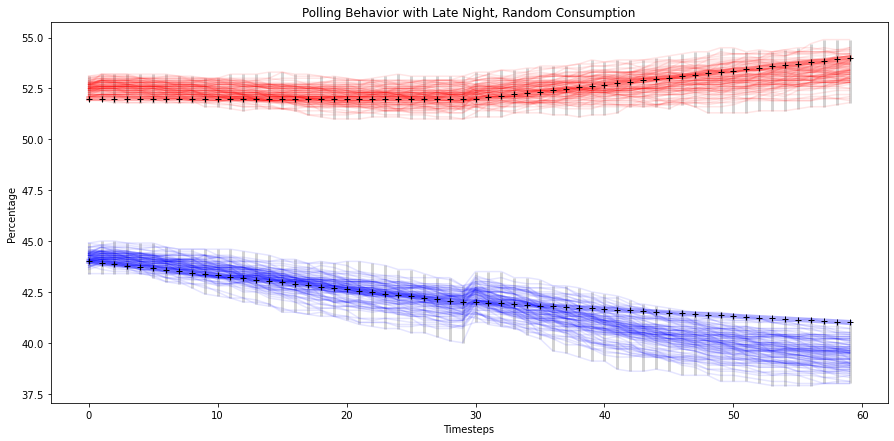

In [125]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
both = np.concatenate((LN_period1, LN_period2), axis=1)
plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)
for i, run in enumerate(both):


    ax.plot(steps, run[:, 0], label="Simulated Approval", linestyle='-',color='blue', alpha=0.1)
    ax.plot(steps, run[:, 1], label="Simulated Disapproval", linestyle='-',color='red', alpha=0.1)

plt.errorbar(steps, ipsos_app, yerr=app_err, fmt='+', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.errorbar(steps, ipsos_dis, yerr=dis_err, fmt='+', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)

array([43.7, 43.6, 43.5, 42.9, 42.8, 42.8, 42.7, 42.8, 42.7, 42.5, 42.4,
       42.4, 42.3, 42.2, 42.1, 42. , 41.8, 41.8, 41.7, 41.5, 41.3, 41.3,
       41.2, 40.9, 40.8, 40.8, 40.8, 40.8, 40.8, 40.7, 41.1, 40.8, 40.6,
       40.4, 40.3, 39.9, 39.9, 39.6, 39.5, 39.3, 39.2, 39.2, 39. , 38.9,
       38.8, 38.7, 38.5, 38.4, 38.4, 38.4, 38.4, 38.3, 38.2, 38.2, 38.2,
       38.2, 38.2, 38.2, 38. , 37.8])

In [90]:
ipsos_app[below[1]].shape

(3790,)

In [13]:
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = opt.x#[ 0.00629773  0.07550578  0.39019542  0.78456869 -0.02043869]

'''
Jokes/Day in Period 1: 4.202088452088452
Jokes/Day in Period 2: 4.8740165631469985
'''
late_night_jokes = 4.202088452088452
m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)


LN_period1 = m.simulate(30, draw=False, coverage_leaning=0.05, late_night_jokes=late_night_jokes, use_starting_agents=True,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


Average approval: -0.10122014161776206 -> -0.10942008659027413

Approval Percentages:  
	strongly approve: 25.5 -> 27.7% 
	somewhat approve: 18.7 -> 14.2% 
	somewhat disapprove: 15.6 -> 13.6% 
	strongly disapprove: 36.9 -> 38.7% 
	no opinion: 3.3 -> 5.8%

Overall Polling Change Predicted:
	Approve: 44.2% -> 41.9%
	Disapprove: 52.5% -> 52.3%


In [14]:
late_night_jokes = 4.8740165631469985
LN_period2 = m.simulate(30, draw=False, coverage_leaning=-0.25, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

Average approval: -0.10942008659027413 -> -0.13217761319794408

Approval Percentages:  
	strongly approve: 27.7 -> 27.4% 
	somewhat approve: 14.2 -> 12.3% 
	somewhat disapprove: 13.6 -> 14.6% 
	strongly disapprove: 38.7 -> 39.2% 
	no opinion: 5.8 -> 6.5%

Overall Polling Change Predicted:
	Approve: 41.9% -> 39.7%
	Disapprove: 52.3% -> 53.8%


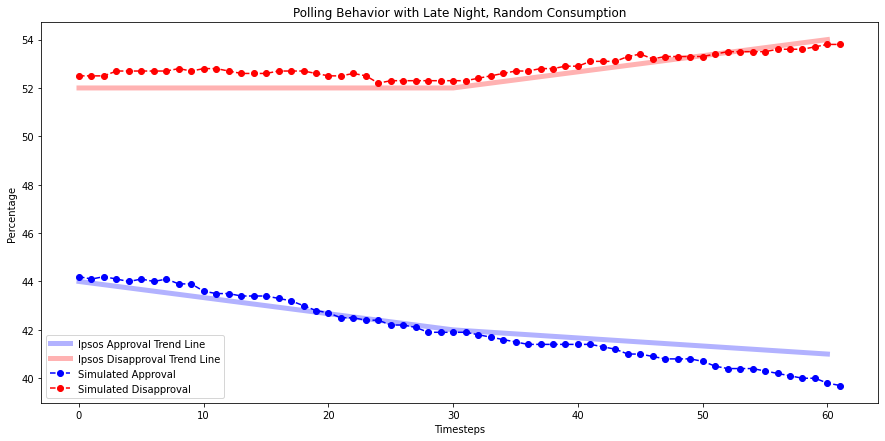

In [15]:
steps = range(62)
plt.figure(figsize=(15, 7))
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)

approval = np.concatenate((LN_period1, LN_period2))

plt.plot(steps, approval[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
plt.plot(steps, approval[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
plt.legend()
plt.show()

NameError: name 'LN_period1' is not defined

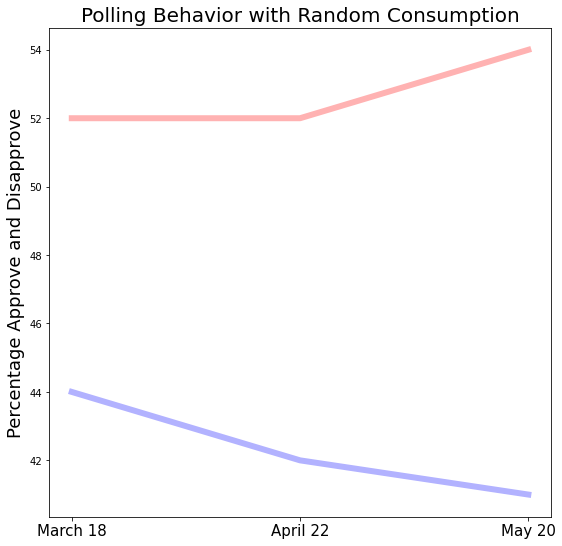

In [18]:
steps = range(61)
plt.figure(figsize=(9, 9))
plt.title("Polling Behavior with Random Consumption", fontsize=20)
#plt.xlabel("Timesteps", fontsize=20)
plt.xticks([0, 30, 60], labels=['March 18', 'April 22', 'May 20'], fontsize=15)
plt.ylabel("Percentage Approve and Disapprove", fontsize=18)

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=6, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=6, alpha=0.3)

LN = np.concatenate((LN_period1, LN_period2[1:]))
NLN = np.concatenate((NLN_period1, NLN_period2[1:]))

plt.plot(steps, LN[:, 0], label="Simulated Approval with Late Night", linestyle='-.',  color='blue', lw=3)
plt.plot(steps, LN[:, 1], label="Simulated Disapproval with Late Night", linestyle='-.',  color='red', lw=3)

plt.plot(steps, NLN[:, 0], label="Simulated Approval without Late Night", linestyle=':',  color='blue', lw=3)
plt.plot(steps, NLN[:, 1], label="Simulated Disapproval without Late Night", linestyle=':', color='red', lw=3)

plt.legend()
plt.show()

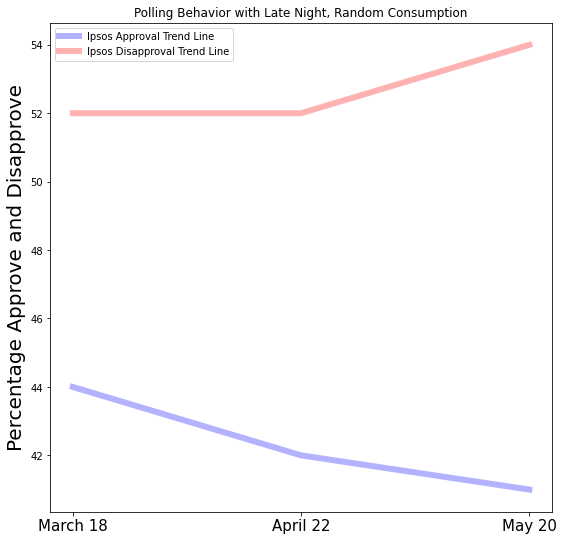

In [96]:
steps = range(61)
plt.figure(figsize=(9, 9))
plt.title("Polling Behavior with Late Night, Random Consumption")
#plt.xlabel("Timesteps", fontsize=20)
plt.xticks([0, 30, 60], labels=['March 18', 'April 22', 'May 20'], fontsize=15)
plt.ylabel("Percentage Approve and Disapprove", fontsize=20)

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=6, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=6, alpha=0.3)


plt.legend()
plt.show()

# No Late Night

In [11]:
'''WITHOUT LATE NIGHT'''
target = [42, 52, 6]


bounds = [(0.005, 0.5), (0.0005, 0.1), (0.0001, 1), (0, 1)]
initial_guess = [0.23987374747543097, 0.008196967677699105, 0.19082355480732427, 0.15832773350644436]

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

results = optimize(m, target, bounds, initial_guess, with_late_night=False)

[43.9, 50.3]  differential_evolution step 1: f(x)= 2.6
[43.0, 49.8] differential_evolution step 2: f(x)= 2.6
[44.8, 50.6]  differential_evolution step 3: f(x)= 2.405
[43.7, 50.0] differential_evolution step 4: f(x)= 2.26
[44.5, 50.7]  differential_evolution step 5: f(x)= 2.26
[43.5, 50.2]  differential_evolution step 6: f(x)= 2.26
[43.7, 50.3] differential_evolution step 7: f(x)= 2.125
[43.8, 50.5]  differential_evolution step 8: f(x)= 2.12
[44.0, 50.4] differential_evolution step 9: f(x)= 1.945
[43.7, 50.2]   differential_evolution step 10: f(x)= 1.945
[44.1, 50.5] differential_evolution step 11: f(x)= 1.945
[43.8, 50.3] differential_evolution step 12: f(x)= 1.945
[43.9, 50.4] differential_evolution step 13: f(x)= 1.945
[45.6, 51.6]  differential_evolution step 14: f(x)= 1.85
[43.9, 50.4]  differential_evolution step 15: f(x)= 1.85
[44.4, 50.4] differential_evolution step 16: f(x)= 1.85
[45.5, 51.6] differential_evolution step 17: f(x)= 1.85
[43.9, 50.5] differential_evolution step 18

In [127]:
'''MULTIPLE RUNS'''

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)
coverage_leaning = 0.05
    
#first period
late_night_jokes = 4.202088452088452
late_night_const=0

target = [42, 52, 6]
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
initial_guess = [0.23785216662772357, 0.07870560089383177, 0.7682381927639791, 0.19322597697871924]
iters = 10
def f(x):
    (threshold, alpha, persuadability_scale, social_media_const) = x
    losses = np.zeros((iters,))
    for i in range(iters):
        m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

        steps = 30
        starting_state = m.starting_state.copy()
        num_agents = len(m.agents)
        
        approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
        

        media_choices = np.zeros((num_agents, steps))
        agent_approvals = []
        consumption_rates = np.zeros((num_agents, ))
        uses_social_media = []
        agent_late_night = []
        neg_persuadability = np.zeros((num_agents,))
        pos_persuadability = np.zeros((num_agents,))

        denom = np.exp(2)-1
        for i, agent in enumerate(m.agents):
            agent_approvals.append(agent.approval)
            consumption_rates[i] = agent.consumption_rate
            uses_social_media.append(agent.uses_social_media)
            agent_late_night.append(agent.late_night)
            neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
            pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
            if len(agent.consume_media()) == 0:
                media_choices[i] = np.array([None]*steps)
            else:
                media_choices[i] = np.random.choice(agent.consume_media(), (steps,))

#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])

        result = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), approval_types, neg_persuadability, pos_persuadability, 
                      threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                      late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False)

        result = result[-1]
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - target[i])**2
        loss /= len(result)
        losses[i] = loss
    mean = np.mean(losses)
    var = np.var(losses)
    print(f'\r Mean: {mean}, Variance: {var}', end=' ', flush=True)
    return mean + var/10

opt = differential_evolution(f, bounds, strategy='best1bin', disp=True, maxiter=25)
opt

 Mean: 0.556999999999999, Variance: 2.79224099999999 01 1 2 differential_evolution step 1: f(x)= 0.0334506
 Mean: 0.4360000000000002, Variance: 1.7108640000000015    differential_evolution step 2: f(x)= 0.0334506
 Mean: 1.1090000000000013, Variance: 11.068929000000029 4  differential_evolution step 3: f(x)= 0.0334506
 Mean: 1.428999999999999, Variance: 18.378368999999967 5  6 differential_evolution step 4: f(x)= 0.0313372
 Mean: 0.40999999999999925, Variance: 1.5128999999999944    differential_evolution step 5: f(x)= 0.0313372
 Mean: 0.18099999999999974, Variance: 0.2948489999999991    differential_evolution step 6: f(x)= 0.018808
 Mean: 0.16, Variance: 0.2304 iance: 0.7568999999999985   5 differential_evolution step 7: f(x)= 0.018808
 Mean: 0.2924999999999996, Variance: 0.7700062499999978     differential_evolution step 8: f(x)= 0.018808
 Mean: 0.27699999999999936, Variance: 0.6905609999999966    differential_evolution step 9: f(x)= 0.018808
 Mean: 0.17999999999999955, Variance: 0.291

     fun: 0.0
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1665
     nit: 25
 success: False
       x: array([0.18942795, 0.41147988, 0.26050008, 0.62035251])

In [20]:
(threshold, alpha, persuadability_scale, social_media_const) = [0.37364163, 0.06361854, 0.4841436,  0.5254433 ]

late_night_jokes = 4.202088452088452
late_night_const = 0

samples = 1000
NLN_period1 = np.zeros((samples, 2))
NLN_period2 = np.zeros((samples, 2))
for i in range(samples):
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)


    NLN_period1[i] = m.simulate(30, draw=False, coverage_leaning=0.05, late_night_jokes=late_night_jokes, use_starting_agents=True,
                   threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
                   late_night_const=late_night_const, social_media_const=social_media_const)


    late_night_jokes = 4.8740165631469985
    NLN_period2[i] = m.simulate(30, draw=False, coverage_leaning=-0.25, late_night_jokes=late_night_jokes,
                   threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
                   late_night_const=late_night_const, social_media_const=social_media_const)

Average approval: -0.11253666712693007 -> -0.10193187078755665

Approval Percentages:  
	strongly approve: 25.5 -> 31.4% 
	somewhat approve: 19.1 -> 14.0% 
	somewhat disapprove: 15.7 -> 18.2% 
	strongly disapprove: 36.9 -> 34.1% 
	no opinion: 2.8 -> 2.3%

Overall Polling Change Predicted:
	Approve: 44.6% -> 45.4%
	Disapprove: 52.6% -> 52.3%


ValueError: could not broadcast input array from shape (31,2) into shape (2)

In [142]:
(threshold, alpha, persuadability_scale, social_media_const) = opt.x#[0.37364163, 0.06361854, 0.4841436,  0.5254433 ]#

late_night_jokes = 4.202088452088452
late_night_const = 0

samples = 1000
steps = 30

NLN_period1 = np.zeros((samples, steps, 2))
NLN_period2 = np.zeros((samples, steps, 2))
for k in range(samples):
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)


    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)

    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


    media_choices = np.zeros((num_agents, steps))
    agent_approvals = []
    consumption_rates = np.zeros((num_agents, ))
    uses_social_media = []
    agent_late_night = []
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))

    denom = np.exp(2)-1
    for i, agent in enumerate(m.agents):
        agent_approvals.append(agent.approval)
        consumption_rates[i] = agent.consumption_rate
        uses_social_media.append(agent.uses_social_media)
        agent_late_night.append(agent.late_night)
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
        else:
            media_choices[i] = np.random.choice(agent.consume_media(), (steps,))

#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])
    
    coverage_leaning = 0.05
    NLN_period1[k] = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False)

    
#     late_night_jokes = 4.8740165631469985
#     media_choices = np.zeros((num_agents, steps))
#     agent_approvals = []
#     consumption_rates = np.zeros((num_agents, ))
#     uses_social_media = []
#     agent_late_night = []

#     for i, agent in enumerate(m.agents):
#         agent_approvals.append(agent.approval)
#         consumption_rates[i] = agent.consumption_rate
#         uses_social_media.append(agent.uses_social_media)
#         agent_late_night.append(agent.late_night)

#         if len(agent.consume_media()) == 0:
#             media_choices[i] = np.array([None]*steps)
#         else:
#             media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
    coverage_leaning = -0.25
    NLN_period2[k] = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False)

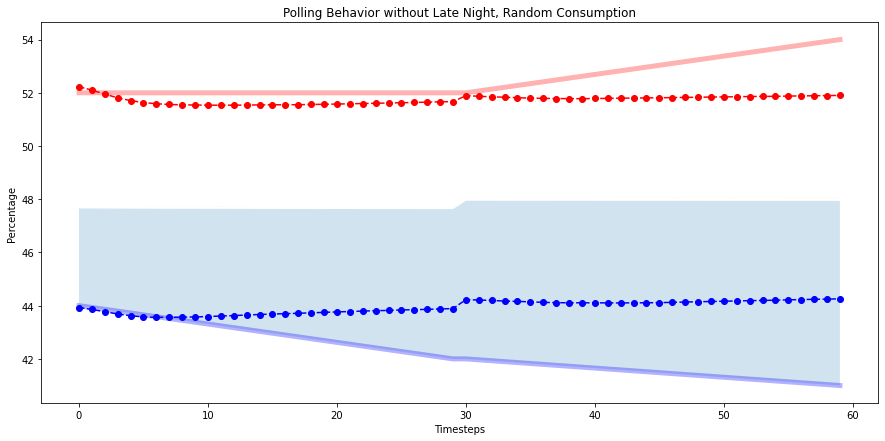

In [163]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
means = np.concatenate((np.mean(NLN_period1, axis=0), np.mean(NLN_period2, axis=0)))
approval = np.concatenate((NLN_period1[:, :, 0], NLN_period2[:, :, 0]), axis=1)
disapproval = np.concatenate((NLN_period1[:, :, 1], NLN_period2[:, :, 1]), axis=1)

app_err = (np.abs(ipsos_app - approval)).std(axis=0)#.mean()#approval.std(axis=0) * np.sqrt(1/len(approval[0]) + (approval - approval.mean(axis=0))**2 / np.sum((approval - approval.mean(axis=0))**2))
dis_err = (np.abs(ipsos_app - approval)).std(axis=0)#.mean()#disapproval.std() * np.sqrt(1/len(disapproval) + (disapproval - disapproval.mean())**2 / np.sum((disapproval - disapproval.mean())**2))

plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)


p1_interval = st.t.interval(alpha=0.99, df=len(NLN_period1)-1, loc=np.mean(NLN_period1), scale=st.sem(NLN_period1))
p2_interval = st.t.interval(alpha=0.99, df=len(NLN_period2)-1, loc=np.mean(NLN_period2), scale=st.sem(NLN_period2))

app_interval = np.concatenate((p1_interval[0], p2_interval[0]))
dis_interval = np.concatenate((p1_interval[1], p2_interval[1]))

ax.plot(steps, means[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
ax.fill_between(steps, ipsos_app, app_interval[:, 1], alpha=0.2)
ax.plot(steps, means[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
ax.fill_between(steps, dis_interval[:, 0], dis_interval[:, 1], alpha=0.5)


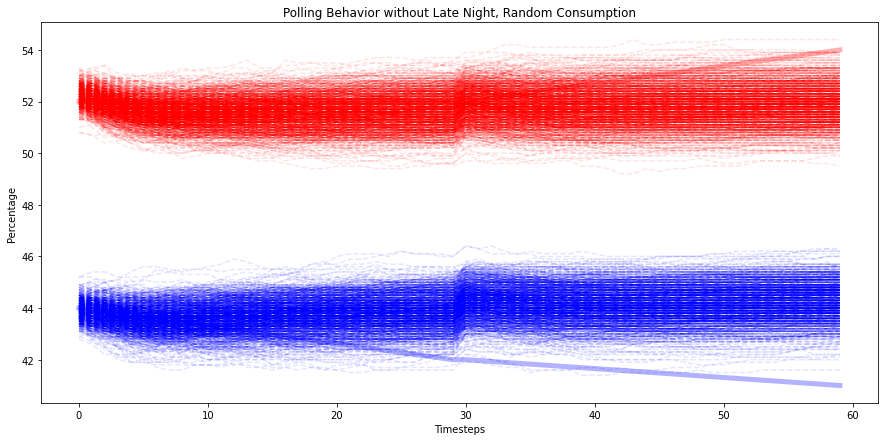

In [144]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
both = np.concatenate((NLN_period1, NLN_period2), axis=1)
plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)
for i, run in enumerate(both):


    ax.plot(steps, run[:, 0], label="Simulated Approval", linestyle='--',color='blue', alpha=0.1)
    ax.plot(steps, run[:, 1], label="Simulated Disapproval", linestyle='--',color='red', alpha=0.1)


In [162]:
both.shape

(1000, 60, 2)

(60, 2)

In [42]:
dist = np.zeros((2, 2))

options = np.array([[0, 1], [1, 0], [0, -1], [1, -1]])
c = np.random.choice([0, 1, 2, 3], 120)
for i in range(len(c)): dist[tuple(options[c[i]])] += 1
dist

array([[ 0., 64.],
       [29., 27.]])

In [43]:
options[1]

array([1, 0])

In [44]:
c

array([1, 0, 0, 1, 3, 0, 3, 3, 1, 2, 1, 0, 1, 1, 3, 2, 1, 1, 0, 1, 0, 3,
       2, 2, 2, 2, 0, 2, 3, 1, 2, 0, 1, 3, 1, 0, 0, 2, 0, 1, 3, 1, 0, 1,
       1, 0, 2, 1, 0, 3, 3, 2, 0, 1, 0, 0, 0, 2, 3, 3, 2, 3, 0, 0, 2, 0,
       2, 0, 0, 2, 0, 2, 3, 1, 3, 2, 3, 2, 0, 0, 1, 2, 2, 2, 2, 1, 3, 3,
       3, 2, 2, 3, 1, 1, 1, 0, 2, 1, 2, 0, 2, 3, 0, 2, 2, 1, 0, 2, 3, 0,
       3, 1, 3, 3, 0, 0, 3, 1, 1, 3])

In [50]:
import scipy.stats as st

#define sample data
data = NLN_period1

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.99, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


NameError: name 'NLN_period1' is not defined

In [152]:
data.shape

(1000, 30, 2)